In [4]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.5 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import random
import time
import warnings
import zipfile
from tqdm import tqdm
import json

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parquet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertTokenizer
from unidecode import unidecode

from src.features.functions_preprocessing import (
    plot_text_length_distribution,
    preprocess_articles,
    preprocess_summaries,
)
from src.features.tokenization import parallel_tokenize
from src.models.bert import BertSummary
from src.models.rnn_encoder_decoder import Encoder, Decoder, Seq2Seq
from src.models.transformer import Transformer
from src.models.train_models import train_model
from src.evaluation.model_evaluation import (
    generate_summaries_seq2seq,
    generate_summaries_transformer,
    generate_summaries_bert,
)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
def get_allowed_cpu_count():
    # Returns the number of CPU cores available for this process.
    try:
        return len(os.sched_getaffinity(0))
    except AttributeError:
        return os.cpu_count() or 1


cpu_count = get_allowed_cpu_count()
print(cpu_count)

104


In [8]:
n_process = max(1, cpu_count // 2)

In [9]:
torch.set_num_threads(n_process)

# **Kaggle dataset**

Download and extract the news summarization dataset from Kaggle, then load it into a pandas DataFrame.

In [ ]:
!pip install kaggle

In [18]:
!unzip "archive(2).zip"

Archive:  archive(2).zip
  inflating: data.csv                


In [ ]:
!kaggle datasets download -d sbhatti/news-summarization

/bin/bash: line 1: /root/.kaggle/kaggle.json: Permission denied


Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
with zipfile.ZipFile("news-summarization.zip", "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [19]:
news_data = pd.read_csv("data.csv")

In [20]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


We pick a random article from the dataset and display both its content and the corresponding summary to compare.

In [21]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

(CNN) -- "Transformers: Age of Extinction" is being called so bad, it hurts. "Hello, police? I'd like to report an assault," begins The Seattle Times review. "Down at the MegaGigaGrandePlex, and it's still going on. Come quick! I barely escaped with my life. The perp? Michael Bay. He gave me a full-body beatdown. His weapon? 'Transformers: Age of Extinction.' " The fourth installment of Michael Bay's toys-to-big-screen franchise is supposed to press reset on the story with a new leading man -- Mark Wahlberg in for Shia LaBeouf -- but critics haven't fallen for it. While Bay has said that he envisions "Age of Extinction" to be the launching pad for a new "Transformers" trilogy to follow the one led by LaBeouf -- which included "Transformers" (2007); "Transformers: Revenge of the Fallen" (2009); and "Transformers: Dark of the Moon" (2011) -- the question critics have asked is whether there needs to be a new trilogy at all. Wahlberg stars in "Age of Extinction" as Texan Cade Yeager, an in

We filter out very short and very long articles (outside the 10th and 90th percentiles) and then plot the length distribution of the remaining articles.

In [22]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [23]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.10))
    & (lengths_article <= lengths_article.quantile(0.90))
]

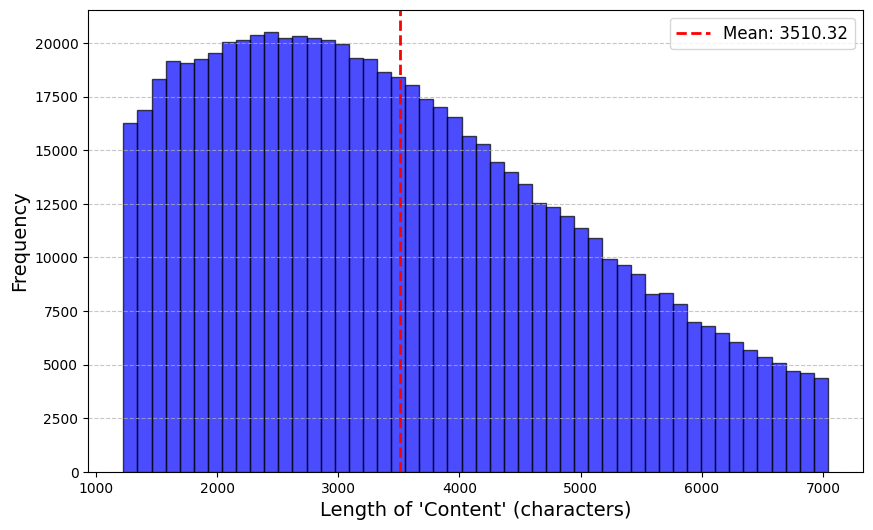

In [24]:
plot_text_length_distribution(news_data, "Content")

We do the same for summaries.

In [25]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    696451.000000
mean        283.484382
std         208.280906
min           1.000000
25%         163.000000
50%         247.000000
75%         326.000000
max        8541.000000
Name: Summary, dtype: float64

In [26]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.10))
    & (lengths_summary <= lengths_summary.quantile(0.90))
]

In [27]:
news_data["Summary"].str.len().describe()

count    558032.00000
mean        250.39556
std          78.90248
min         120.00000
25%         189.00000
50%         247.00000
75%         307.00000
max         435.00000
Name: Summary, dtype: float64

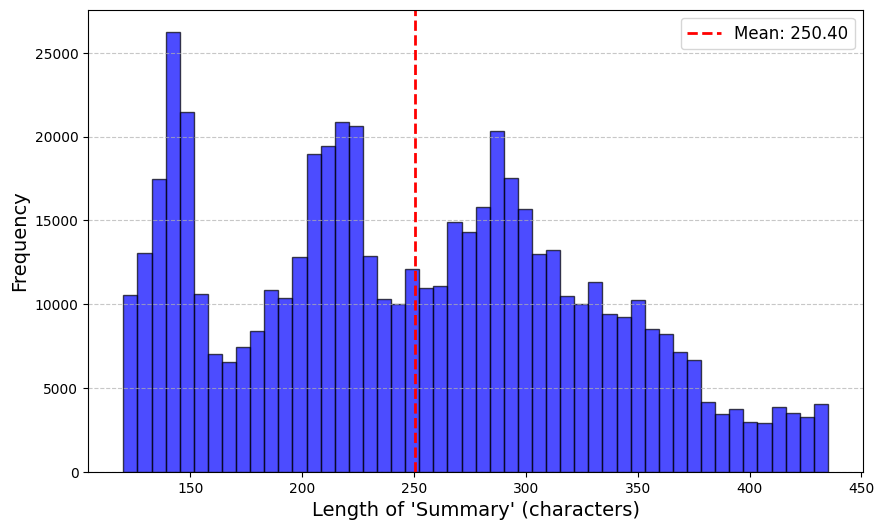

In [28]:
plot_text_length_distribution(news_data, "Summary")

In [29]:
len(news_data)

558032

We preprocess the articles and summaries using parallel processing to clean and standardize the text data efficiently.

In [ ]:
news_data.loc[:, "Content"] = preprocess_articles(
    news_data["Content"].tolist(), n_process=n_process, batch_size=32
)
news_data.loc[:, "Summary"] = preprocess_summaries(
    news_data["Summary"].tolist(), n_process=n_process, batch_size=32
)

In [ ]:
news_data.to_parquet("news_data_cleaned.parquet", index=False)

In [ ]:
news_data = pd.read_parquet("news_data_cleaned.parquet")

# **Tokenization**

We shuffle the dataset, split it into training and testing sets with an 80-20 ratio, and print the sizes of both subsets.

In [ ]:
data_copy = news_data[:]
data_copy = news_data.sample(frac=1, random_state=42)

train_ratio = 0.8
train_size = int(train_ratio * len(data_copy))

# Slice the dataset
train_data = data_copy[:train_size]
test_data = data_copy[train_size:]

print(f"Train size: {len(train_data)}")
print(f"Test size:  {len(test_data)}")

We tokenize the content of the articles & summaries in parallel using a BERT tokenizer, then save the tokenized result as a PyTorch tensor.

In [ ]:
if __name__ == "__main__":
    texts_content = list(train_data["Content"])
    print("Tokenizing Content...")
    tokenized_articles = parallel_tokenize(
        texts_content,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=512,
    )
    print("tokenized_articles.shape =", tokenized_articles.shape)
    torch.save(tokenized_articles, "tokenized_articles.pt")

In [ ]:
if __name__ == "__main__":
    texts_summary = list(train_data["Summary"])
    print("Tokenizing Summaries...")
    tokenized_summaries = parallel_tokenize(
        texts_summary,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=129,
    )
    print("tokenized_summaries.shape =", tokenized_summaries.shape)
    torch.save(tokenized_summaries, "tokenized_summaries.pt")

In [ ]:
if __name__ == "__main__":
    texts_content = list(test_data["Content"])
    print("Tokenizing Content...")
    tokenized_articles_test = parallel_tokenize(
        texts_content,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=512,
    )
    print("tokenized_articles.shape =", tokenized_articles_test.shape)
    torch.save(tokenized_articles_test, "tokenized_articles_test.pt")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tokenized_articles = torch.load("tokenized_articles.pt")
    tokenized_summaries = torch.load("tokenized_summaries.pt")
    tokenized_summaries_bert = torch.load("tokenized_summaries_bert.pt")
    tokenized_articles_test = torch.load("tokenized_articles_test.pt")

In [ ]:
tokenized_summaries_bert = torch.cat(
    [torch.zeros(tokenized_summaries_bert.size(0), 1), tokenized_summaries_bert], dim=1
).long()

In [ ]:
article_ids = tokenized_articles.long()
summary_ids = tokenized_summaries.long()

# **Transformer**

We create a dataset and dataloader, then initialize a Transformer model with BERT's vocabulary size, hidden size, 8 attention heads, and 3 layers.

In [ ]:
batch_size = 32

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers=n_process, shuffle=True
)

In [ ]:
modelTransformer = Transformer(
    pad_idx=0,
    voc_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=512,
    ffn_hidden=128,
    n_layers=3,
)

We train the Transformer model for 25 epochs using the Adam optimizer and cross-entropy loss.

In [ ]:
train_model(
    model=modelTransformer,
    dataloader=dataloader,
    num_epochs=25,
    optimizer=torch.optim.Adam(modelTransformer.parameters(), lr=2e-4),
    loss_fn=nn.CrossEntropyLoss(
        ignore_index=BertTokenizer.from_pretrained("bert-base-uncased").pad_token_id
    ),
    model_name="Transformer",
    device=device,
)

We initialize the Transformer model, load the pre-trained weights from a previous run (after 25 epochs), and set the model to evaluation mode.

In [ ]:
modelTransformer = Transformer(
    pad_idx=0,
    voc_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=128,
    ffn_hidden=128,
    n_layers=3,
)
modelTransformer.load_state_dict(
    torch.load("model_weights/transformer_weights_25_epochs.pth")
)
modelTransformer.eval()

# **Evaluation**

We load the ROUGE evaluation metric, which is commonly used to assess the quality of generated text summaries by comparing them to reference summaries.

In [ ]:
rouge = evaluate.load("rouge")

## Transformer

We generate summaries using the Transformer model.

In [ ]:
predictions_transformer = generate_summaries_transformer(
    model=modelTransformer,
    batch_size=32,
    tokenized_input=tokenized_articles_test,
    limit=None,
)

In [ ]:
test_data.loc[:, "predictions_transformer"] = predictions_transformer

We compute ROUGE metrics by comparing the Transformer model's generated summaries to the reference summaries from the test set.

In [ ]:
reference_summaries = list(test_data["Summary"])
results = rouge.compute(
    predictions=predictions_transformer, references=reference_summaries
)
print("ROUGE metrics:", results)